### Libraries & Settings

In [648]:
import os
import warnings
import itertools

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# %matplotlib notebook

### Data

#### Data Preparation

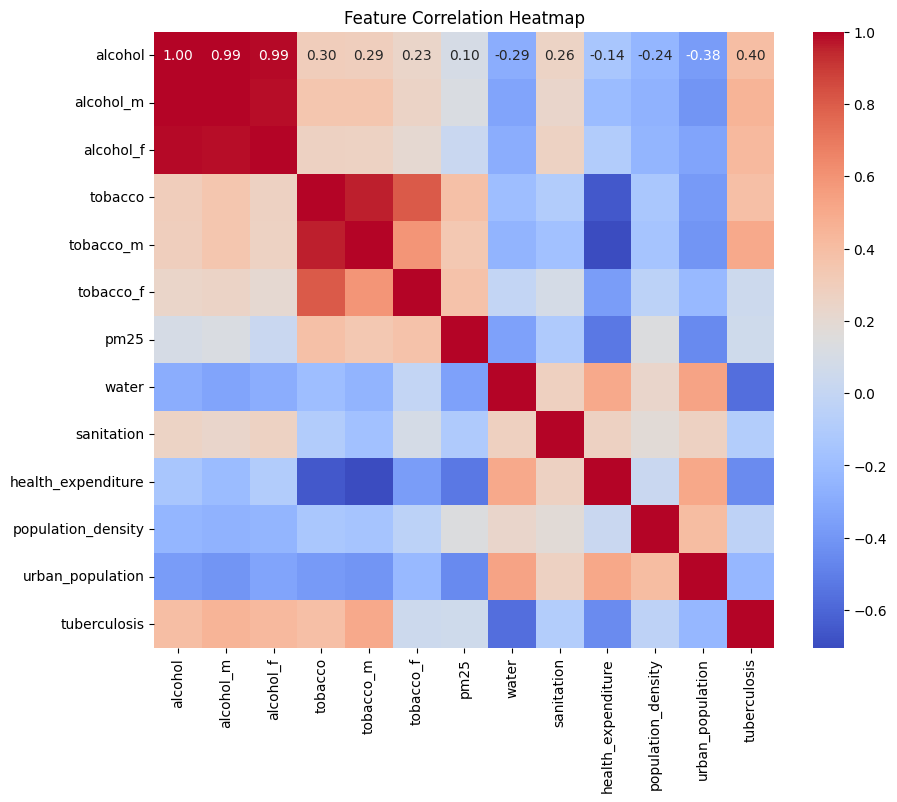

                     alcohol  alcohol_m  alcohol_f   tobacco  tobacco_m  \
alcohol             1.000000   0.994498   0.992435  0.300565   0.290608   
alcohol_m           0.994498   1.000000   0.984321  0.354251   0.353927   
alcohol_f           0.992435   0.984321   1.000000  0.269681   0.264076   
tobacco             0.300565   0.354251   0.269681  1.000000   0.954086   
tobacco_m           0.290608   0.353927   0.264076  0.954086   1.000000   
tobacco_f           0.234852   0.254318   0.203942  0.806690   0.593579   
pm25                0.099910   0.124497   0.025097  0.384046   0.335459   
water              -0.288294  -0.334680  -0.288200 -0.193205  -0.256252   
sanitation          0.259573   0.231356   0.266907 -0.095127  -0.172491   
health_expenditure -0.140048  -0.211261  -0.092711 -0.654356  -0.703961   
population_density -0.244532  -0.261213  -0.246423 -0.131971  -0.157639   
urban_population   -0.376519  -0.410740  -0.334719 -0.379090  -0.405252   
tuberculosis        0.396

In [649]:
train_data_percentage = 0.8
train_data_path = 'train_data.csv'
test_data_path = 'test_data.csv'

if os.path.exists(train_data_path) and os.path.exists(test_data_path):
    dataset_train = pd.read_csv(train_data_path)
    dataset_test = pd.read_csv(test_data_path)
else:
    # Parameters & Functions
    selected_country_codes = ['GBR', 'FRA', 'DEU', 'ITA', 'NLD', 'NOR', 'SWE', 'FIN', 'DNK', 'ISL', 'CHE', 'BEL', 'LUX', 'IRL', 'ESP', 'PRT', 'AUT', 'CZE', 'SVK', 'HUN', 'GRC', 'SVN', 'POL', 'EST', 'LVA', 'LTU', 'MLT', 'CYP'] # , 'SMR'
    selected_year_codes = list(map(str, range(2010, 2023 + 1)))

    def select_dataframe(data_frame):
        return data_frame[data_frame['Country Code'].isin(selected_country_codes)].iloc[:, :-1].reset_index(drop = True)

    def organize_dataframe(data_frame, value_name):
        res = pd.melt(data_frame, id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], var_name = 'Year Code', value_name = value_name)[['Country Code', 'Year Code', value_name]]
        res[value_name] = res.groupby('Country Code')[value_name].ffill().bfill()
        return res[res['Year Code'].isin(selected_year_codes)]

    # Load .csv files
    csv_path = '../data/'

    alcohol_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'alcohol_consumption_per_capita.csv'))) # Liter of pure alcohol per capita
    alcohol_male_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'alcohol_consumption_per_capita_male.csv'))) # Liter of pure alcohol per capita, male
    alcohol_female_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'alcohol_consumption_per_capita_female.csv'))) # Liter of pure alcohol per capita, female
    tobacco_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'prevalence_of_current_tobacco_use.csv'))) # % of adults
    tobacco_male_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'prevalence_of_current_tobacco_use_male.csv'))) # % of male adults
    tobacco_female_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'prevalence_of_current_tobacco_use_female.csv'))) # % of female adults
    pm25_pollution_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'PM2.5_air_pollution.csv'))) # Micrograms per cubic meter
    safely_managed_drinking_water_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'safely_managed_drinking_water.csv'))) # % of population
    safely_managed_sanitation_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'safely_managed_sanitation.csv'))) # % of population
    government_health_expenditure_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'domestic_general_government_health_expenditure_per_capita.csv'))) # USD, PPP
    population_density_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'population_density.csv'))) # People per sq. km of land area
    urban_population_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'urban_population.csv'))) # % of total population

    # diabetes_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'diabetes_prevalence.csv'))) # % of population ages 20 to 79
    tuberculosis_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'incidence_of_tuberculosis.csv'))) # per 100,000 people
    # mortality_specified_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'mortality_from_CVD_cancer_diabetes_CRD.csv'))) # % of population ages 30 and 70
    # mortality_specified_male_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'mortality_from_CVD_cancer_diabetes_CRD_male.csv'))) # % of male population ages 30 and 70
    # mortality_specified_female_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'mortality_from_CVD_cancer_diabetes_CRD_female.csv'))) # % of female population ages 30 and 70

    # Organize data
    alcohol_df = organize_dataframe(alcohol_csv, 'alcohol') # Alcohol Consumption
    merged_df = alcohol_df

    alcohol_male_df = organize_dataframe(alcohol_male_csv, 'alcohol_m') # Alcohol Consumption (M)
    merged_df = pd.merge(merged_df, alcohol_male_df, on = ['Country Code', 'Year Code'], how = 'outer')

    alcohol_female_df = organize_dataframe(alcohol_female_csv, 'alcohol_f') # Alcohol Consumption (F)
    merged_df = pd.merge(merged_df, alcohol_female_df, on = ['Country Code', 'Year Code'], how = 'outer')

    tobacco_df = organize_dataframe(tobacco_csv, 'tobacco') # Tobacco Use
    merged_df = pd.merge(merged_df, tobacco_df, on = ['Country Code', 'Year Code'], how = 'outer')

    tobacco_male_df = organize_dataframe(tobacco_male_csv, 'tobacco_m') # Tobacco Use (M)
    merged_df = pd.merge(merged_df, tobacco_male_df, on = ['Country Code', 'Year Code'], how = 'outer')

    tobacco_female_df = organize_dataframe(tobacco_female_csv, 'tobacco_f') # Tobacco Use (F)
    merged_df = pd.merge(merged_df, tobacco_female_df, on = ['Country Code', 'Year Code'], how = 'outer')

    pm25_pollution_df = organize_dataframe(pm25_pollution_csv, 'pm25') # PM2.5 Air Pollution
    merged_df = pd.merge(merged_df, pm25_pollution_df, on = ['Country Code', 'Year Code'], how = 'outer')

    safely_managed_drinking_water_df = organize_dataframe(safely_managed_drinking_water_csv, 'water') # People With Safely Managed Drinking Water
    merged_df = pd.merge(merged_df, safely_managed_drinking_water_df, on = ['Country Code', 'Year Code'], how = 'outer')

    safely_managed_sanitation_df = organize_dataframe(safely_managed_sanitation_csv, 'sanitation') # People With Safely Managed Sanitation
    merged_df = pd.merge(merged_df, safely_managed_sanitation_df, on = ['Country Code', 'Year Code'], how = 'outer')

    government_health_expenditure_df = organize_dataframe(government_health_expenditure_csv, 'health_expenditure') # Domestic General Government Health Expenditure Per Capita
    merged_df = pd.merge(merged_df, government_health_expenditure_df, on = ['Country Code', 'Year Code'], how = 'outer')

    population_density_df = organize_dataframe(population_density_csv, 'population_density') # Population Density
    merged_df = pd.merge(merged_df, population_density_df, on = ['Country Code', 'Year Code'], how = 'outer')

    urban_population_df = organize_dataframe(urban_population_csv, 'urban_population') # Urban Population
    merged_df = pd.merge(merged_df, urban_population_df, on = ['Country Code', 'Year Code'], how = 'outer')

    # diabetes_df = organize_dataframe(diabetes_csv, 'diabetes') # Diabetes Prevalence
    # merged_df = pd.merge(merged_df, diabetes_df, on = ['Country Code', 'Year Code'], how = 'outer')

    tuberculosis_df = organize_dataframe(tuberculosis_csv, 'tuberculosis') # Tuberculosis Incidence
    merged_df = pd.merge(merged_df, tuberculosis_df, on = ['Country Code', 'Year Code'], how = 'outer')

    # mortality_specified_df = organize_dataframe(mortality_specified_csv, 'mortality') # Mortality (Specified Types)
    # merged_df = pd.merge(merged_df, mortality_specified_df, on = ['Country Code', 'Year Code'], how = 'outer')

    # mortality_specified_male_df = organize_dataframe(mortality_specified_male_csv, 'mortality_m') # Mortality (Specified Types, M)
    # merged_df = pd.merge(merged_df, mortality_specified_male_df, on = ['Country Code', 'Year Code'], how = 'outer')

    # mortality_specified_female_df = organize_dataframe(mortality_specified_female_csv, 'mortality_f') # Mortality (Specified Types, F)
    # merged_df = pd.merge(merged_df, mortality_specified_female_df, on = ['Country Code', 'Year Code'], how = 'outer')

    merged_df = merged_df.drop(columns = ['Country Code', 'Year Code']).dropna().reset_index(drop = True)

    # Correlation Heatmap (Primtive)
    plt.figure(figsize = (10, 8))
    sns.heatmap(merged_df.corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')
    plt.title('Feature Correlation Heatmap')
    plt.show()
    print(merged_df.corr())

    # Add sex column and substitute total values
    def add_sex_dummy_variable(dataset):
        def get_reserved_terms(row):
            return {
                'pm25': row['pm25'],
                'water': row['water'],
                'sanitation': row['sanitation'],
                'health_expenditure': row['health_expenditure'],
                'population_density': row['population_density'],
                'urban_population': row['urban_population'],
                # 'diabetes': row['diabetes'],
                'tuberculosis': row['tuberculosis']
            }
        rows = []
        for i, row in dataset.iterrows():
            rows.append({'sex': 0, 'alcohol': row['alcohol_m'], 'tobacco': row['tobacco_m'], **get_reserved_terms(row)}) # , 'mortality': row['mortality_m']})
            rows.append({'sex': 1, 'alcohol': row['alcohol_f'], 'tobacco': row['tobacco_f'], **get_reserved_terms(row)}) # , 'mortality': row['mortality_f']})
        return pd.DataFrame(rows)
    dataset = add_sex_dummy_variable(merged_df)

    # Features
    feature_names = ['sex', 'alcohol', 'tobacco', 'pm25', 'water', 'sanitation', 'health_expenditure', 'population_density', 'urban_population']
    
    # Divide into train and test data
    dataset_train, dataset_test = train_test_split(dataset, test_size = 1 - train_data_percentage, random_state = 233)
    dataset_train = dataset_train.reset_index(drop = True)
    dataset_test = dataset_test.reset_index(drop = True)

    # Save data
    # dataset_train.to_csv(train_data_path, index = False)
    # dataset_test.to_csv(test_data_path, index = False)

#### Testing the Data

##### Response

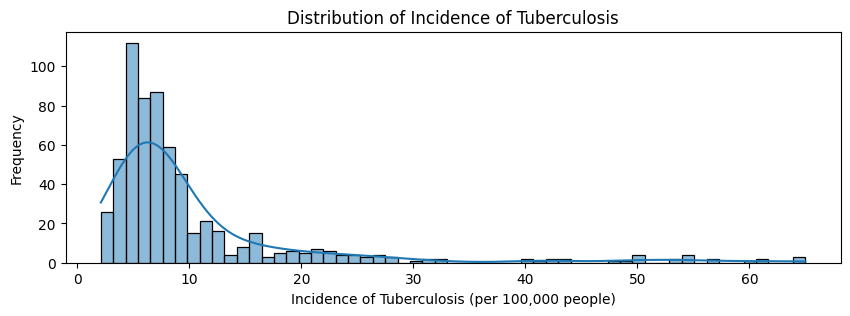

In [650]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category = Warning)

    plt.figure(figsize = (10, 3))
    sns.histplot(dataset_train['tuberculosis'], kde = True)
    plt.title('Distribution of Incidence of Tuberculosis')
    plt.xlabel('Incidence of Tuberculosis (per 100,000 people)')
    plt.ylabel('Frequency')
    plt.show()

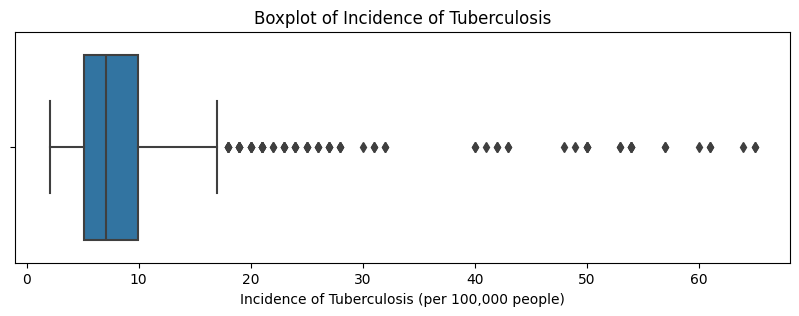

Descriptive Statistics for Incidence of Tuberculosis:
count    627.000000
mean      10.405104
std       10.459724
min        2.100000
25%        5.150000
50%        7.100000
75%        9.950000
max       65.000000
Name: tuberculosis, dtype: float64


In [651]:
descriptive_stats = dataset_train['tuberculosis'].describe()

plt.figure(figsize = (10, 3))
sns.boxplot(x = dataset_train['tuberculosis']) # , color = 'lightseagreen')
plt.title('Boxplot of Incidence of Tuberculosis')
plt.xlabel('Incidence of Tuberculosis (per 100,000 people)')
plt.show()

print("Descriptive Statistics for Incidence of Tuberculosis:")
print(descriptive_stats)

##### Correlation Matrix

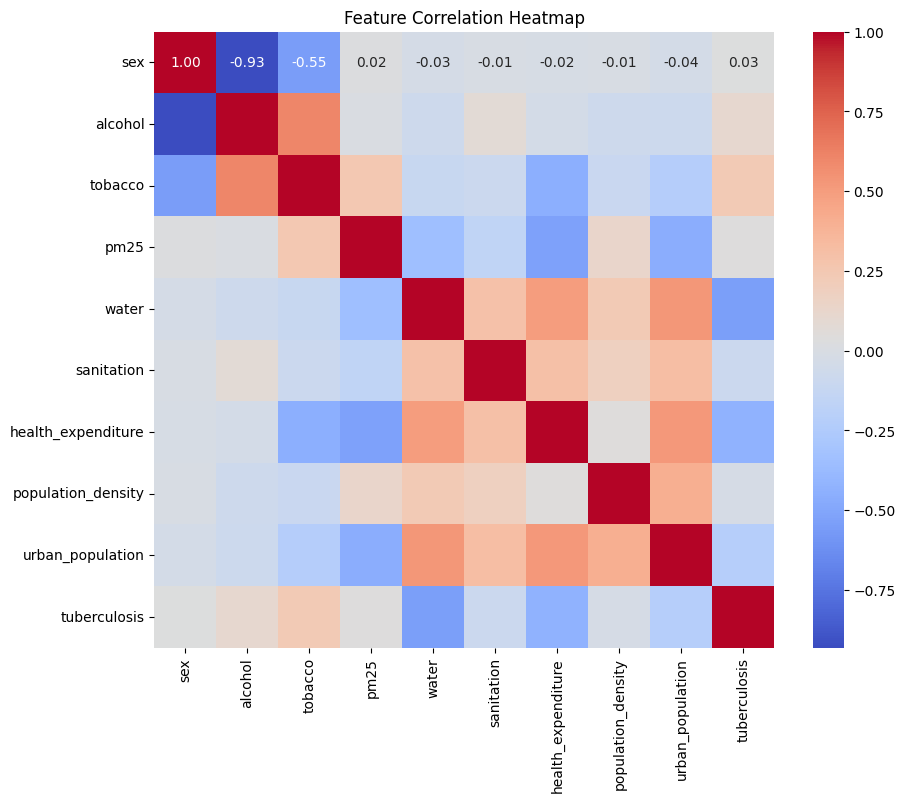

                         sex   alcohol   tobacco      pm25     water  \
sex                 1.000000 -0.931203 -0.546870  0.020056 -0.028356   
alcohol            -0.931203  1.000000  0.604046  0.008393 -0.072553   
tobacco            -0.546870  0.604046  1.000000  0.248257 -0.111098   
pm25                0.020056  0.008393  0.248257  1.000000 -0.345237   
water              -0.028356 -0.072553 -0.111098 -0.345237  1.000000   
sanitation         -0.005258  0.072299 -0.091799 -0.155194  0.291317   
health_expenditure -0.018276 -0.036608 -0.448723 -0.524661  0.501238   
population_density -0.008677 -0.075639 -0.102496  0.128101  0.236071   
urban_population   -0.038805 -0.081450 -0.223866 -0.457831  0.527656   
tuberculosis        0.030884  0.107953  0.237629  0.039022 -0.541611   

                    sanitation  health_expenditure  population_density  \
sex                  -0.005258           -0.018276           -0.008677   
alcohol               0.072299           -0.036608         

In [652]:
plt.figure(figsize = (10, 8))
sns.heatmap(dataset_train.corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Feature Correlation Heatmap')
plt.show()
print(dataset_train.corr())

##### Pairplot

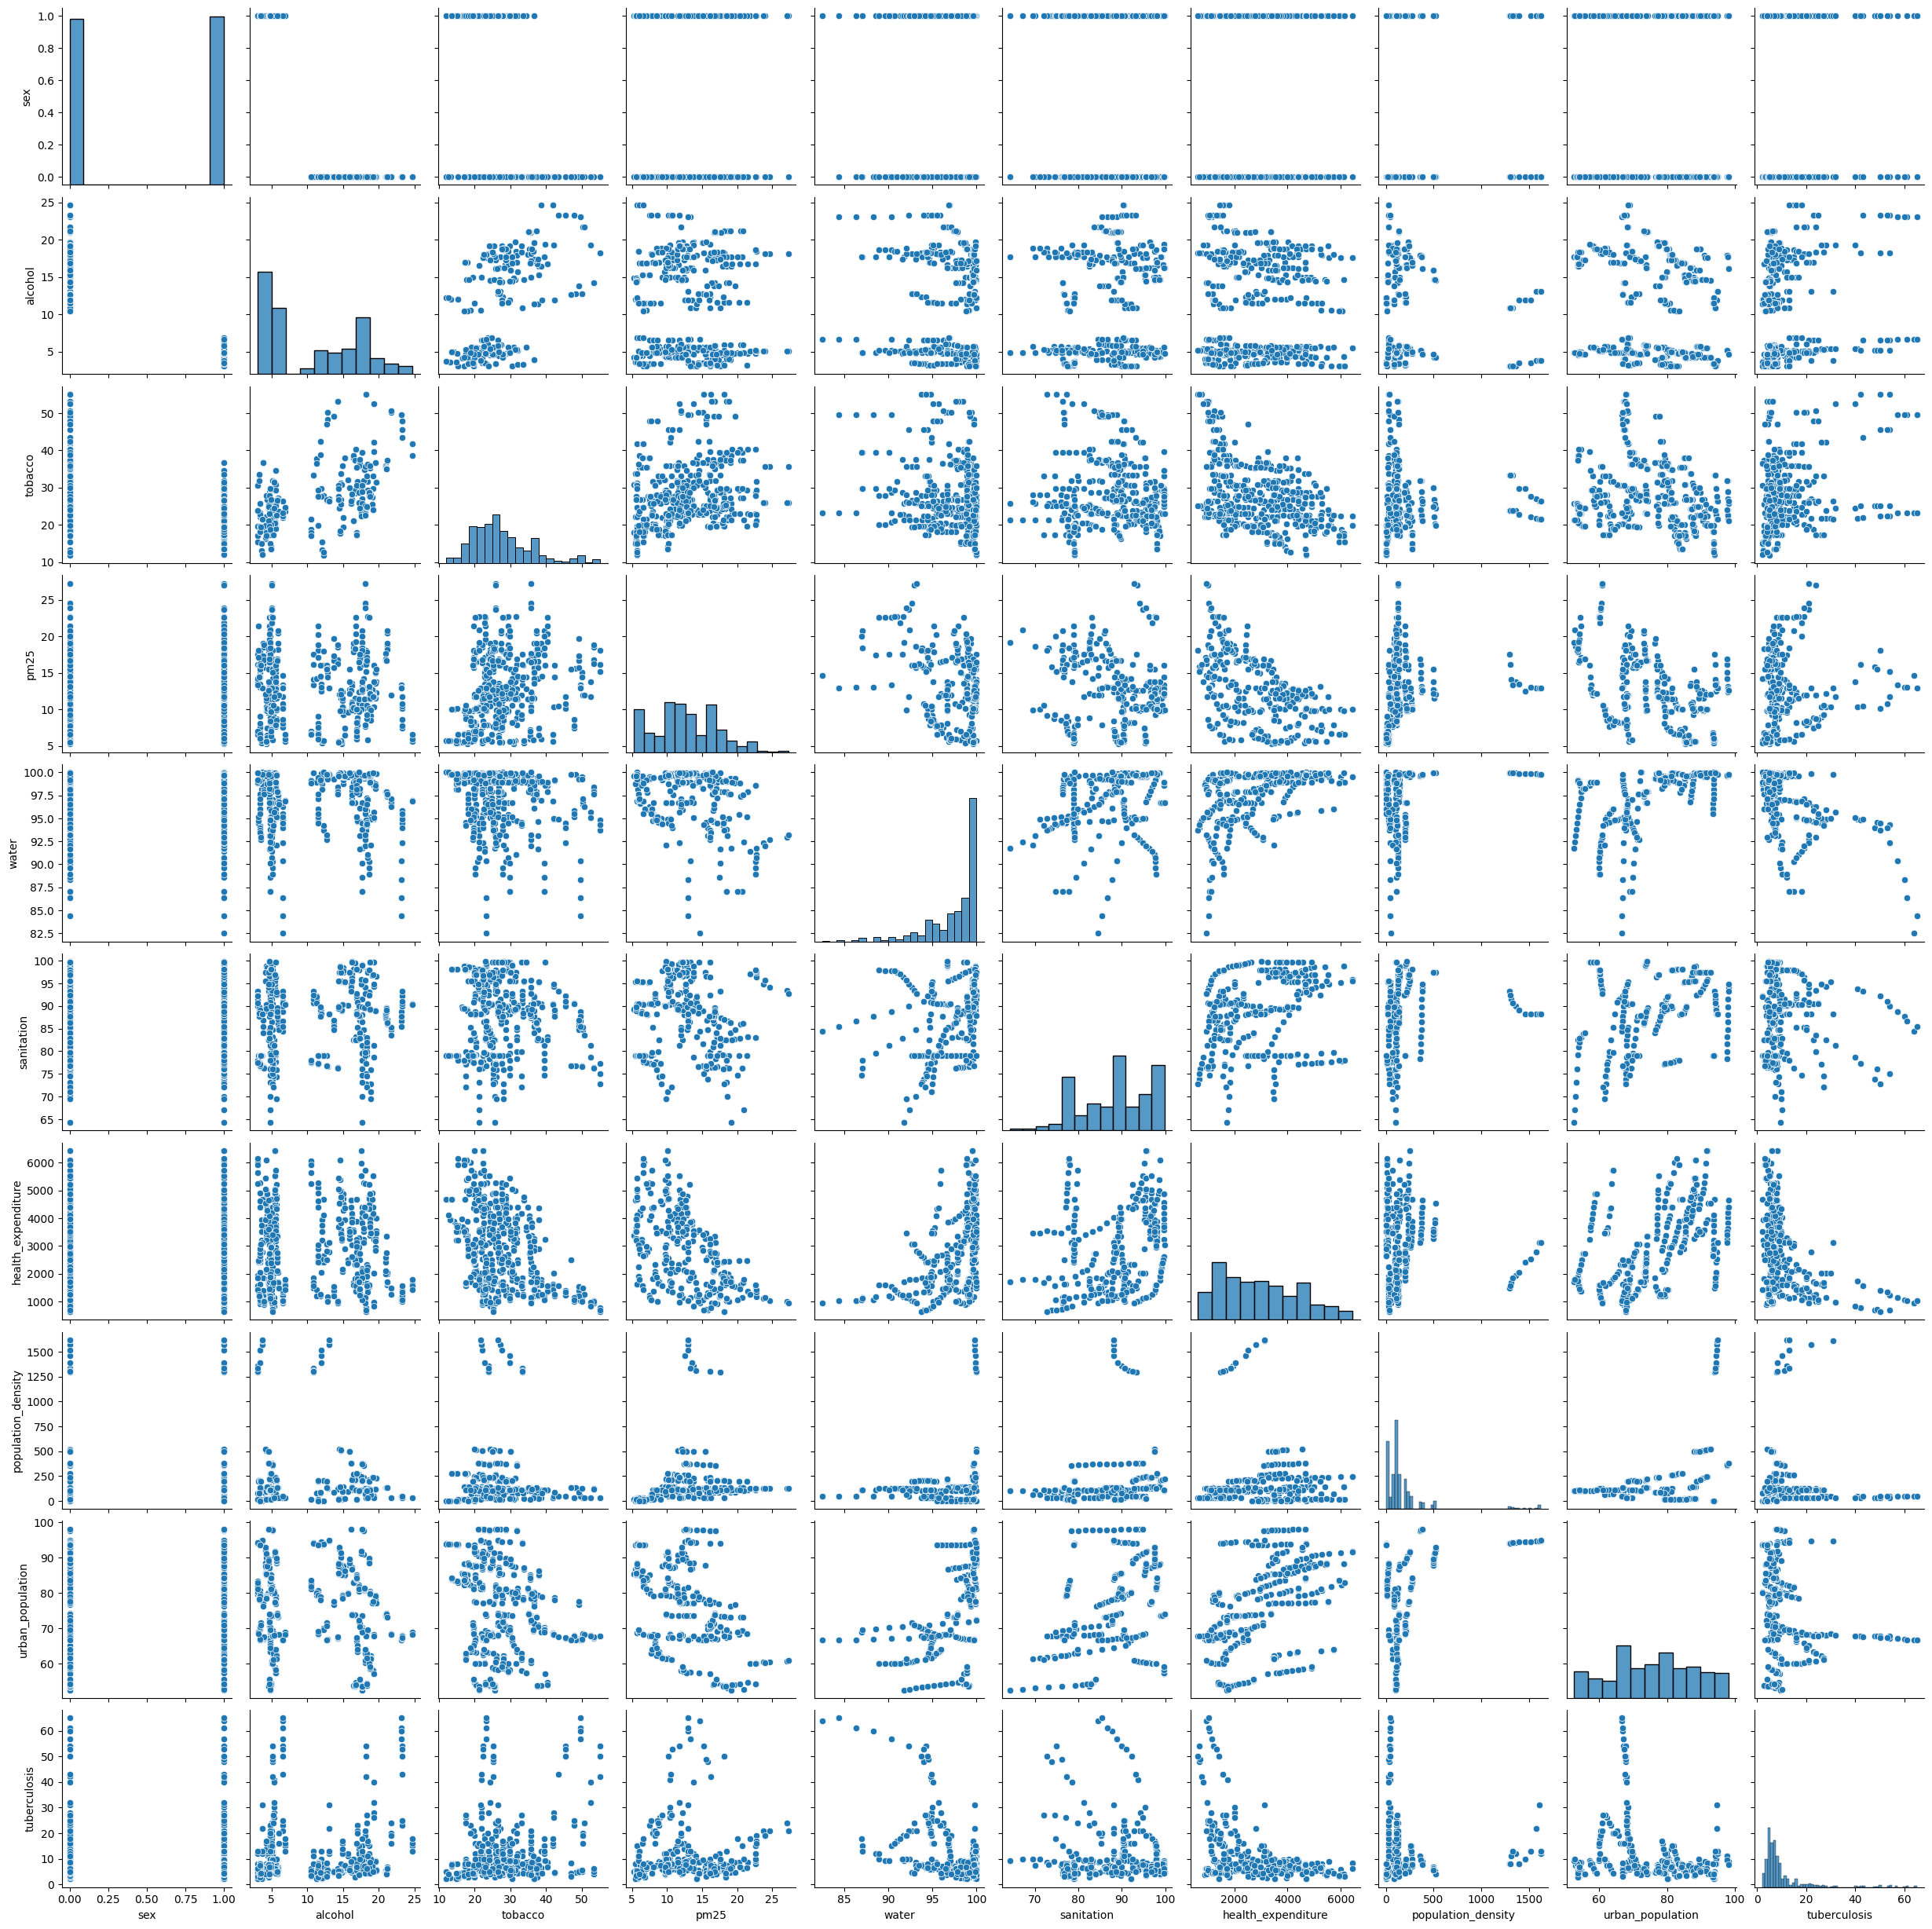

In [653]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category = Warning)

    sns.pairplot(dataset_train)
    plt.show()

### Modeling

#### Multiple Linear Regression

In [654]:
def mlr_process(response, predictors):
    # Prepare data
    y_train = dataset_train[response].copy()
    X_train = dataset_train[predictors].copy()
    y_test = dataset_test[response].copy()
    X_test = dataset_test[predictors].copy()

    # Add constant
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # Train
    model = sm.OLS(y_train, X_train).fit()

    # Test
    y_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    return model, y_pred - y_test, test_mse, test_r2

model_mlr, test_residuals_mlr, test_mse_mlr, test_r2_mlr = mlr_process('tuberculosis', feature_names) # , list(set(feature_names) - set(['sanitation'])))
print(f'\nTest Results:')
print(f'\tMean Squared Error: {test_mse_mlr:.4f}')
print(f'\tR^2: {test_r2_mlr:.4f}\n')
print(model_mlr.summary())


Test Results:
	Mean Squared Error: 40.2230
	R^2: 0.6273

                            OLS Regression Results                            
Dep. Variable:           tuberculosis   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     69.55
Date:                Wed, 29 May 2024   Prob (F-statistic):           6.12e-88
Time:                        08:59:35   Log-Likelihood:                -2141.5
No. Observations:                 627   AIC:                             4303.
Df Residuals:                     617   BIC:                             4347.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

#### Decision Tree


Test Results:
	Mean Squared Error: 4.4578
	R^2: 0.9587



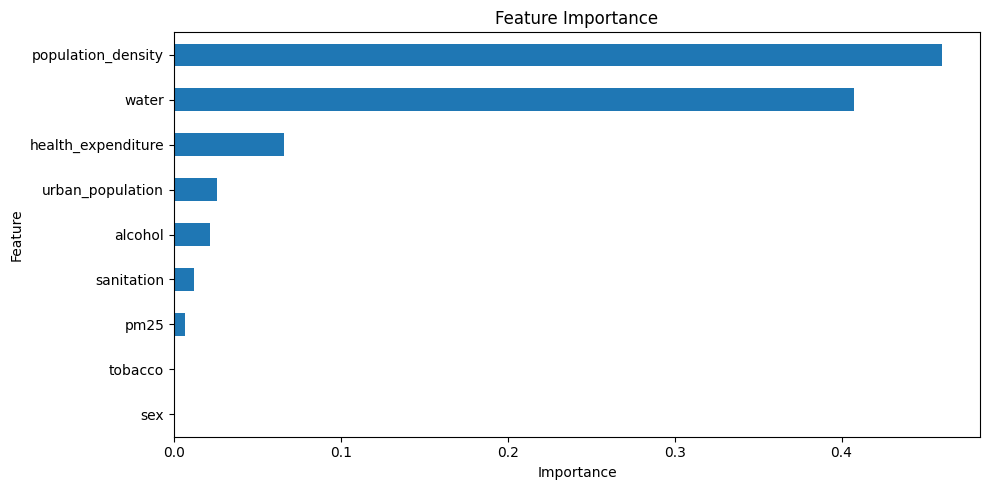

In [686]:
def dt_process(response, predictors):
    # Prepare data
    y_train = dataset_train[response].copy()
    X_train = dataset_train[predictors].copy()
    y_test = dataset_test[response].copy()
    X_test = dataset_test[predictors].copy()

    # Train
    model = DecisionTreeRegressor(random_state = 233)
    model.fit(X_train, y_train)

    # Test
    y_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    return model, y_pred - y_test, test_mse, test_r2

model_dt, test_residuals_dt, test_mse_dt, test_r2_dt = dt_process('tuberculosis', feature_names)
print(f'\nTest Results:')
print(f'\tMean Squared Error: {test_mse_dt:.4f}')
print(f'\tR^2: {test_r2_dt:.4f}\n')

importance = pd.DataFrame({
    'Feature': model_dt.feature_names_in_,
    'Importance': model_dt.feature_importances_
}).sort_values(by = 'Importance', ascending = True)

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
importance.plot(kind = 'barh', x = 'Feature', y = 'Importance', ax = ax, legend = False)
ax.set_title('Feature Importance')
ax.set_xlabel('Importance')
plt.tight_layout()
plt.show()

#### Random Forest


Test Results:
	Mean Squared Error: 1.9627
	R^2: 0.9818



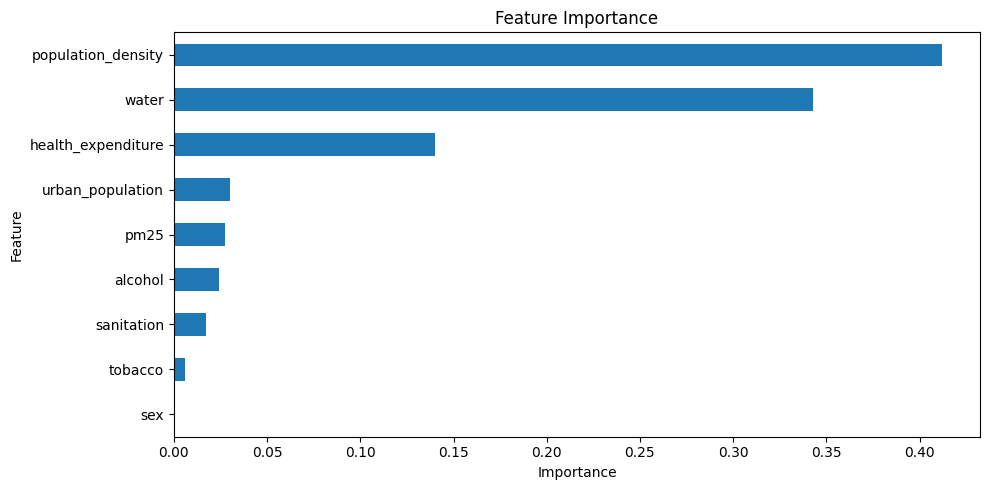

In [687]:
def rf_process(response, predictors):
    # Prepare data
    y_train = dataset_train[response].copy()
    X_train = dataset_train[predictors].copy()
    y_test = dataset_test[response].copy()
    X_test = dataset_test[predictors].copy()

    # Train
    model = RandomForestRegressor(random_state = 233)
    model.fit(X_train, y_train)

    # Test
    y_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    return model, y_pred - y_test, test_mse, test_r2

model_rf, test_residuals_rf, test_mse_rf, test_r2_rf = rf_process('tuberculosis', feature_names)
print(f'\nTest Results:')
print(f'\tMean Squared Error: {test_mse_rf:.4f}')
print(f'\tR^2: {test_r2_rf:.4f}\n')

importance = pd.DataFrame({
    'Feature': model_rf.feature_names_in_,
    'Importance': model_rf.feature_importances_
}).sort_values(by = 'Importance', ascending = True)

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
importance.plot(kind = 'barh', x = 'Feature', y = 'Importance', ax = ax, legend = False)
ax.set_title('Feature Importance')
ax.set_xlabel('Importance')
plt.tight_layout()
plt.show()

#### Support Vector Regression

In [657]:
def svr_process(response, predictors, kernel):
    # Prepare data
    y_train = dataset_train[response].copy()
    X_train = dataset_train[predictors].copy()
    y_test = dataset_test[response].copy()
    X_test = dataset_test[predictors].copy()

    # Train
    model = SVR(kernel = kernel) # 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
    model.fit(X_train, y_train)

    # Test
    y_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    return model, y_pred - y_test, test_mse, test_r2

model_svr, test_residuals_svr, test_mse_svr, test_r2_svr = svr_process('tuberculosis', feature_names, 'rbf')
print(f'\nTest Results:')
print(f'\tMean Squared Error: {test_mse_svr:.4f}')
print(f'\tR^2: {test_r2_svr:.4f}\n')


Test Results:
	Mean Squared Error: 104.6991
	R^2: 0.0298



#### Multi-Layer Perceptron

In [658]:
def mlp_process(response, predictors, hidden_layer_sizes = (50, ), max_iter = 1000):
    # Prepare data
    y_train = dataset_train[response].copy()
    X_train = dataset_train[predictors].copy()
    y_test = dataset_test[response].copy()
    X_test = dataset_test[predictors].copy()

    # Train
    model = MLPRegressor(hidden_layer_sizes = hidden_layer_sizes, max_iter = max_iter, random_state = 233)
    model.fit(X_train, y_train)

    # Test
    y_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    return model, y_pred - y_test, test_mse, test_r2

model_mlp, test_residuals_mlp, test_mse_mlp, test_r2_mlp = mlp_process('tuberculosis', feature_names)
print(f'\nTest Results:')
print(f'\tMean Squared Error: {test_mse_mlp:.4f}')
print(f'\tR^2: {test_r2_mlp:.4f}\n')


Test Results:
	Mean Squared Error: 40.4337
	R^2: 0.6253



### Improvement

#### Interaction Terms

In [659]:
def mlr_process_interaction(response, predictors):
    # Prepare data
    y_train = dataset_train[response].copy()
    X_train = dataset_train[predictors].copy()
    y_test = dataset_test[response].copy()
    X_test = dataset_test[predictors].copy()

    for other in ['alcohol', 'tobacco']:
        term = f'sex * {other}'
        X_train[term] = X_train['sex'] * X_train[other]
        X_test[term] = X_test['sex'] * X_test[other]

    for other in ['tobacco', 'pm25', 'water', 'sanitation']:
        term = f'health_expenditure * {other}'
        X_train[term] = X_train['health_expenditure'] * X_train[other]
        X_test[term] = X_test['health_expenditure'] * X_test[other]

    # for i in range(len(predictors)):
    #     for j in range(i + 1, len(predictors)):
    #         predictor_1 = predictors[i]
    #         predictor_2 = predictors[j]
    #         interaction_term = f'{predictor_1} * {predictor_2}'
    #         X_train[interaction_term] = X_train[predictor_1] * X_train[predictor_2]
    #         X_test[interaction_term] = X_test[predictor_1] * X_test[predictor_2]

    # X_train['water ^ 2'] = X_train['water'] ** 2
    # X_test['water ^ 2'] = X_test['water'] ** 2
    # for i in range(3, 7 + 1):
    #     X_train[f'water ^ {i}'] = X_train[f'water ^ {i - 1}'] * X_train['water']
    #     X_test[f'water ^ {i}'] = X_test[f'water ^ {i - 1}'] * X_test['water']

    # Add constant
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # Train
    model = sm.OLS(y_train, X_train).fit()

    # Test
    y_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    return model, y_pred - y_test, test_mse, test_r2

model_mlri, test_residuals_mlri, test_mse_mlri, test_r2_mlri = mlr_process_interaction('tuberculosis', feature_names)
print(f'\nTest Results:')
print(f'\tMean Squared Error: {test_mse_mlri:.4f}')
print(f'\tR^2: {test_r2_mlri:.4f}\n')
print(model_mlri.summary())


Test Results:
	Mean Squared Error: 25.6760
	R^2: 0.7621

                            OLS Regression Results                            
Dep. Variable:           tuberculosis   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     73.61
Date:                Wed, 29 May 2024   Prob (F-statistic):          5.37e-126
Time:                        08:59:36   Log-Likelihood:                -2037.5
No. Observations:                 627   AIC:                             4107.
Df Residuals:                     611   BIC:                             4178.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------


Test Results:
	Mean Squared Error: 1.4678
	R^2: 0.9864



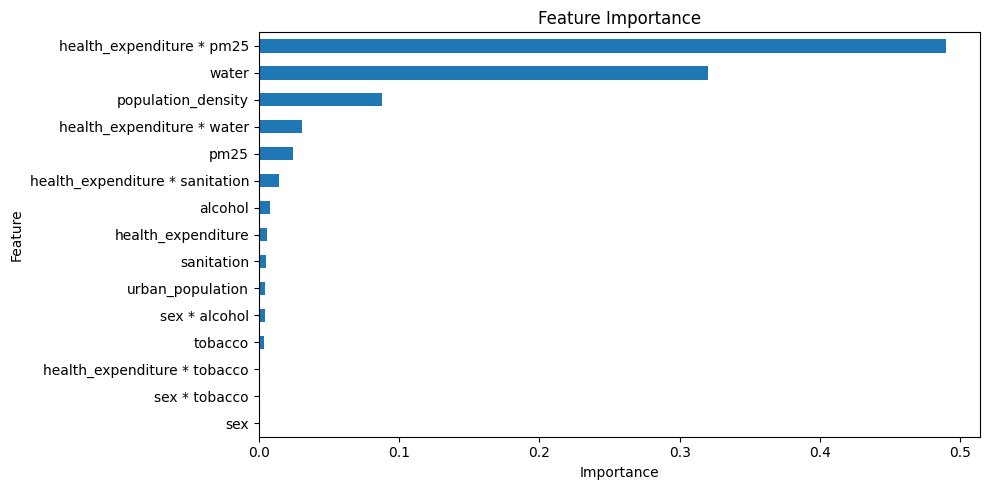

In [685]:
def dt_process_interaction(response, predictors):
    # Prepare data
    y_train = dataset_train[response].copy()
    X_train = dataset_train[predictors].copy()
    y_test = dataset_test[response].copy()
    X_test = dataset_test[predictors].copy()

    for other in ['alcohol', 'tobacco']:
        term = f'sex * {other}'
        X_train[term] = X_train['sex'] * X_train[other]
        X_test[term] = X_test['sex'] * X_test[other]

    for other in ['tobacco', 'pm25', 'water', 'sanitation']:
        term = f'health_expenditure * {other}'
        X_train[term] = X_train['health_expenditure'] * X_train[other]
        X_test[term] = X_test['health_expenditure'] * X_test[other]

    # Train
    model = DecisionTreeRegressor(random_state = 233)
    model.fit(X_train, y_train)

    # Test
    y_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    return model, y_pred - y_test, test_mse, test_r2

model_dti, test_residuals_dti, test_mse_dti, test_r2_dti = dt_process_interaction('tuberculosis', feature_names)
print(f'\nTest Results:')
print(f'\tMean Squared Error: {test_mse_dti:.4f}')
print(f'\tR^2: {test_r2_dti:.4f}\n')

importance = pd.DataFrame({
    'Feature': model_dti.feature_names_in_,
    'Importance': model_dti.feature_importances_
}).sort_values(by = 'Importance', ascending = True)

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
importance.plot(kind = 'barh', x = 'Feature', y = 'Importance', ax = ax, legend = False)
ax.set_title('Feature Importance')
ax.set_xlabel('Importance')
plt.tight_layout()
plt.show()


Test Results:
	Mean Squared Error: 1.6903
	R^2: 0.9843



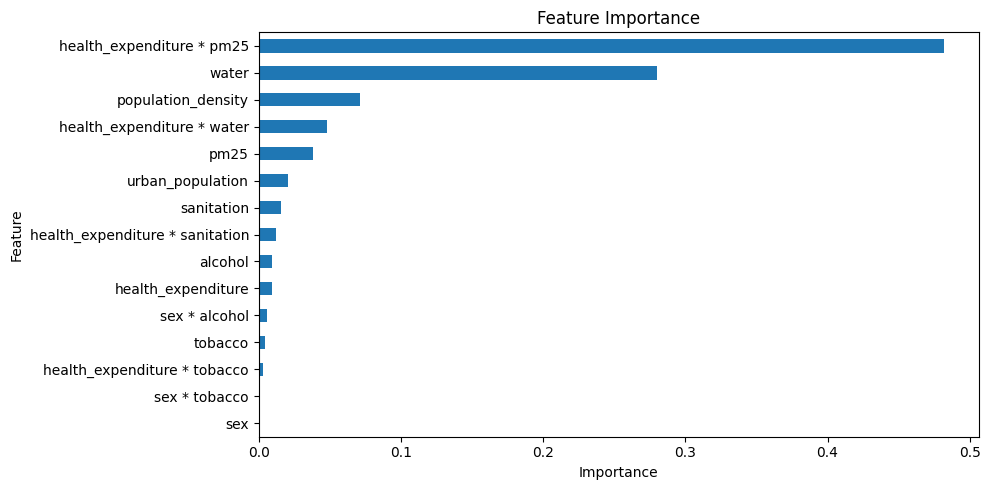

In [684]:
def rf_process_interaction(response, predictors):
    # Prepare data
    y_train = dataset_train[response].copy()
    X_train = dataset_train[predictors].copy()
    y_test = dataset_test[response].copy()
    X_test = dataset_test[predictors].copy()

    for other in ['alcohol', 'tobacco']:
        term = f'sex * {other}'
        X_train[term] = X_train['sex'] * X_train[other]
        X_test[term] = X_test['sex'] * X_test[other]

    for other in ['tobacco', 'pm25', 'water', 'sanitation']:
        term = f'health_expenditure * {other}'
        X_train[term] = X_train['health_expenditure'] * X_train[other]
        X_test[term] = X_test['health_expenditure'] * X_test[other]

    # Train
    model = RandomForestRegressor(random_state = 233)
    model.fit(X_train, y_train)

    # Test
    y_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    return model, y_pred - y_test, test_mse, test_r2

model_rfi, test_residuals_rfi, test_mse_rfi, test_r2_rfi = rf_process_interaction('tuberculosis', feature_names)
print(f'\nTest Results:')
print(f'\tMean Squared Error: {test_mse_rfi:.4f}')
print(f'\tR^2: {test_r2_rfi:.4f}\n')

importance = pd.DataFrame({
    'Feature': model_rfi.feature_names_in_,
    'Importance': model_rfi.feature_importances_
}).sort_values(by = 'Importance', ascending = True)

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
importance.plot(kind = 'barh', x = 'Feature', y = 'Importance', ax = ax, legend = False)
ax.set_title('Feature Importance')
ax.set_xlabel('Importance')
plt.tight_layout()
plt.show()

#### Stepwise Selection

##### Forward Selection

In [661]:
def mlr_process_interaction_forward_selection(response, predictors, threshold_in = 0.05):
    # Initialize variables
    included = []
    best_mse = float('inf')
    best_r2 = float('-inf')

    # Prepare data and interaction terms
    y_train = dataset_train[response].copy()
    X_train = dataset_train[predictors].copy()
    y_test = dataset_test[response].copy()
    X_test = dataset_test[predictors].copy()
    for i in range(len(feature_names)):
        for j in range(i + 1, len(feature_names)):
            predictor_1 = feature_names[i]
            predictor_2 = feature_names[j]
            interaction_term = f'{predictor_1} * {predictor_2}'
            X_train[interaction_term] = X_train[predictor_1] * X_train[predictor_2]
            X_test[interaction_term] = X_test[predictor_1] * X_test[predictor_2]
    
    all_predictors = feature_names + [f'{f1} * {f2}' for f1, f2 in itertools.combinations(feature_names, 2)]
    while True:
        changed = False
        # Evaluate remaining predictors
        excluded = list(set(all_predictors) - set(included))
        new_pvals = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[included + [new_column]]))).fit()
            new_pvals[new_column] = model.pvalues[new_column]
        best_pval = new_pvals.min()
        if best_pval < threshold_in:
            best_feature = new_pvals.idxmin()
            included.append(best_feature)
            changed = True
            
            # Evaluate model with selected features
            model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[included]))).fit()
            y_pred = model.predict(sm.add_constant(pd.DataFrame(X_test[included])))

            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            if mse < best_mse:
                best_model = model
                best_residuals = y_pred - y_test
                best_mse = mse
                best_r2 = r2
            else:
                # If adding the new feature doesn't improve the model, remove it
                included.remove(best_feature)
                changed = False

        if not changed:
            break
    
    return included, best_model, best_residuals, best_mse, best_r2

selected_features, model_mlri_fs, test_residuals_mlri_fs, test_mse_mlri_fs, test_r2_mlri_fs = mlr_process_interaction_forward_selection('tuberculosis', feature_names)
print(f'\nResults:')
print(f'\tSelected Features: {selected_features}')
print(f'\tBest Mean Squared Error: {test_mse_mlri_fs:.4f}')
print(f'\tBest R^2: {test_r2_mlri_fs:.4f}')
print(model_mlri_fs.summary())


Results:
	Selected Features: ['water', 'pm25 * health_expenditure', 'health_expenditure * population_density', 'pm25 * population_density', 'tobacco * sanitation', 'sex * alcohol', 'alcohol * tobacco']
	Best Mean Squared Error: 35.4460
	Best R^2: 0.6715
                            OLS Regression Results                            
Dep. Variable:           tuberculosis   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     113.8
Date:                Wed, 29 May 2024   Prob (F-statistic):          7.74e-107
Time:                        08:59:37   Log-Likelihood:                -2101.7
No. Observations:                 627   AIC:                             4219.
Df Residuals:                     619   BIC:                             4255.
Df Model:                           7                                         
Covariance Type:            nonrob

##### Mixed Selection

In [662]:
def mlr_process_interaction_mixed_selection(response, predictors, threshold_in = 0.05, threshold_out = 0.05):
    # Initialize variables
    included = []
    best_mse = float('inf')
    best_r2 = float('-inf')

    # Prepare data and interaction terms
    y_train = dataset_train[response].copy()
    X_train = dataset_train[predictors].copy()
    y_test = dataset_test[response].copy()
    X_test = dataset_test[predictors].copy()
    for i in range(len(feature_names)):
        for j in range(i + 1, len(feature_names)):
            predictor_1 = feature_names[i]
            predictor_2 = feature_names[j]
            interaction_term = f'{predictor_1} * {predictor_2}'
            X_train[interaction_term] = X_train[predictor_1] * X_train[predictor_2]
            X_test[interaction_term] = X_test[predictor_1] * X_test[predictor_2]

    all_predictors = feature_names + [f'{f1} * {f2}' for f1, f2 in itertools.combinations(feature_names, 2)]
    
    while True:
        changed = False
        # Forward Step
        excluded = list(set(all_predictors) - set(included))
        new_pvals = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[included + [new_column]]))).fit()
            new_pvals[new_column] = model.pvalues[new_column]
        best_pval = new_pvals.min()
        if best_pval < threshold_in:
            best_feature = new_pvals.idxmin()
            included.append(best_feature)
            changed = True
            
        # Backward Step
        while True:
            model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[included]))).fit()
            pvalues = model.pvalues.iloc[1:]  # Exclude the intercept
            worst_pval = pvalues.max()
            if worst_pval > threshold_out:
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                changed = True
            else:
                break

        # Evaluate model with selected features
        if changed:
            model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[included]))).fit()
            y_pred = model.predict(sm.add_constant(pd.DataFrame(X_test[included])))

            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            if mse < best_mse:
                best_model = model
                best_residuals = y_pred - y_test
                best_mse = mse
                best_r2 = r2
        else:
            break
    
    return included, best_model, best_residuals, best_mse, best_r2

selected_features, model_mlri_ms, test_residuals_mlri_ms, test_mse_mlri_ms, test_r2_mlri_ms = mlr_process_interaction_mixed_selection('tuberculosis', feature_names)
print(f'\nResults:')
print(f'\tSelected Features: {selected_features}')
print(f'\tBest Mean Squared Error: {test_mse_mlri_ms:.4f}')
print(f'\tBest R^2: {test_r2_mlri_ms:.4f}')
print(model_mlri_ms.summary())


Results:
	Selected Features: ['water', 'pm25 * health_expenditure', 'health_expenditure * population_density', 'tobacco * sanitation', 'sex * alcohol', 'alcohol * tobacco', 'sex * health_expenditure', 'sanitation * health_expenditure', 'sex * tobacco', 'sex * pm25', 'alcohol * water', 'alcohol * sanitation', 'sex * water', 'sex * urban_population']
	Best Mean Squared Error: 33.3072
	Best R^2: 0.6914
                            OLS Regression Results                            
Dep. Variable:           tuberculosis   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     88.54
Date:                Wed, 29 May 2024   Prob (F-statistic):          6.03e-119
Time:                        08:59:39   Log-Likelihood:                -2063.5
No. Observations:                 627   AIC:                             4151.
Df Residuals:                     615   BIC

#### PCA

In [681]:
def pca_dataset(X_train, X_test, features_to_pca, features_num_target, new_feature_prefix):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(dataset_train[features_to_pca])
    X_test_scaled = scaler.transform(dataset_test[features_to_pca])

    pca = PCA(n_components = features_num_target)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    X_train_pca_df = pd.DataFrame(X_train_pca, columns = [f'{new_feature_prefix}_{i}' for i in range(features_num_target)])
    X_test_pca_df = pd.DataFrame(X_test_pca, columns = [f'{new_feature_prefix}_{i}' for i in range(features_num_target)])

    X_train = X_train.drop(columns = [*features_to_pca])
    X_test = X_test.drop(columns = [*features_to_pca])

    X_train = pd.concat([X_train.reset_index(drop = True), X_train_pca_df.reset_index(drop = True)], axis = 1)
    X_test = pd.concat([X_test.reset_index(drop = True), X_test_pca_df.reset_index(drop = True)], axis = 1)

    return X_train, X_test

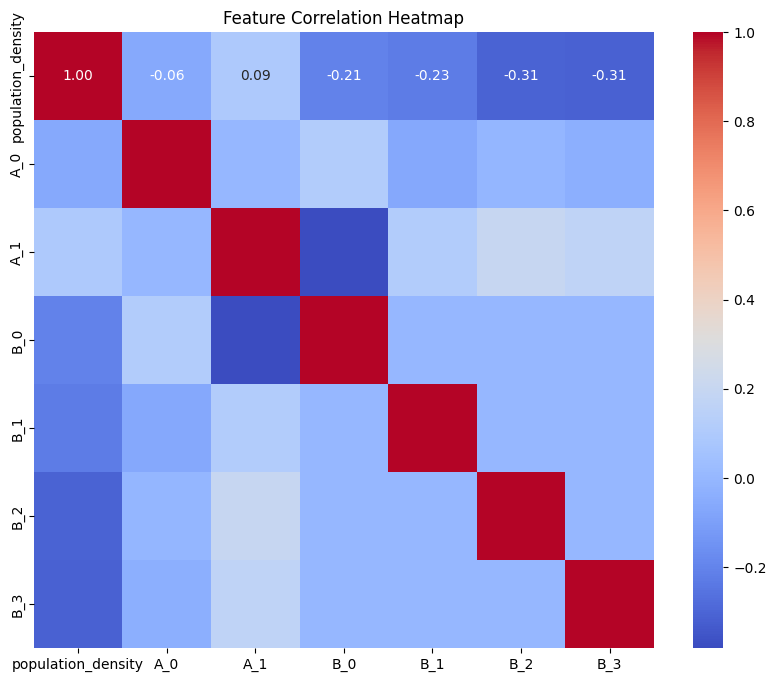

                         sex   alcohol   tobacco      pm25     water  \
sex                 1.000000 -0.931203 -0.546870  0.020056 -0.028356   
alcohol            -0.931203  1.000000  0.604046  0.008393 -0.072553   
tobacco            -0.546870  0.604046  1.000000  0.248257 -0.111098   
pm25                0.020056  0.008393  0.248257  1.000000 -0.345237   
water              -0.028356 -0.072553 -0.111098 -0.345237  1.000000   
sanitation         -0.005258  0.072299 -0.091799 -0.155194  0.291317   
health_expenditure -0.018276 -0.036608 -0.448723 -0.524661  0.501238   
population_density -0.008677 -0.075639 -0.102496  0.128101  0.236071   
urban_population   -0.038805 -0.081450 -0.223866 -0.457831  0.527656   
tuberculosis        0.030884  0.107953  0.237629  0.039022 -0.541611   

                    sanitation  health_expenditure  population_density  \
sex                  -0.005258           -0.018276           -0.008677   
alcohol               0.072299           -0.036608         

In [680]:
def mlr_process_pca(response, predictors):
    # Prepare data
    X_train = dataset_train.drop(columns = [response])
    X_test = dataset_test.drop(columns = [response])

    # PCA
    X_train, X_test = pca_dataset(X_train, X_test, ['sex', 'alcohol', 'tobacco'], 2, 'A')
    X_train, X_test = pca_dataset(X_train, X_test, ['pm25', 'water', 'sanitation', 'health_expenditure', 'urban_population'], 4, 'B')
    
    plt.figure(figsize = (10, 8))
    sns.heatmap(X_train.corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')
    plt.title('Feature Correlation Heatmap')
    plt.show()
    print(dataset_train.corr())

    y_train = dataset_train[response].copy()
    y_test = dataset_test[response].copy()

    # Add constant
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # Train
    model = sm.OLS(y_train, X_train).fit()

    # Test
    y_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    return model, y_pred - y_test, test_mse, test_r2

model_mlrp, test_residuals_mlrp, test_mse_mlrp, test_r2_mlrp = mlr_process_pca('tuberculosis', feature_names)
print(f'\nTest Results:')
print(f'\tMean Squared Error: {test_mse_mlrp:.4f}')
print(f'\tR^2: {test_r2_mlrp:.4f}\n')
print(model_mlrp.summary())

#### Cross Validation

In [664]:
# TODO
def cross_val_mlr(response, predictors, dataset, n_splits=5):
    y = dataset[response].values
    X = dataset[predictors].values

    # Create KFold cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=233)

    mse_scores = []
    r2_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Add constant
        X_train = sm.add_constant(X_train)
        X_test = sm.add_constant(X_test)

        model = sm.OLS(y_train, X_train).fit()
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        mse_scores.append(mse)
        r2_scores.append(r2)

    return mse_scores, r2_scores

mse_scores, r2_scores = cross_val_mlr('tuberculosis', feature_names, dataset_train, n_splits=5)
print(f'\nCross-Validation Results:')
print(f'\tAverage Mean Squared Error: {mse_scores}')
print(f'\tAverage R^2: {r2_scores}')


Cross-Validation Results:
	Average Mean Squared Error: [72.04239683453365, 46.13564600149451, 51.25238361373701, 46.717232016689586, 63.06194156912176]
	Average R^2: [0.3929948711574509, 0.44474316303437333, 0.5463796939697938, 0.4049001094504293, 0.5826891850023262]


### Analysis

#### Residuals

Test MSE & R2 Score:
	Decision Tree (Interaction Terms)		1.4678		0.9864
	Random Forest (Interaction Terms)		1.6903		0.9843
	Random Forest					1.9627		0.9818
	Decision Tree					4.4578		0.9587
	Multiple Linear Regression (Interaction Terms)	25.6760		0.7621
	Multiple Linear Regression (Mixed Selection)	33.3072		0.6914
	Multiple Linear Regression (Forward Selection)	35.4460		0.6715
	Multiple Linear Regression			40.2230		0.6273
	Multi-Layer Perceptron				40.4337		0.6253
	Multiple Linear Regression (PCA)		43.1034		0.6006
	Support Vector Regression			104.6991	0.0298


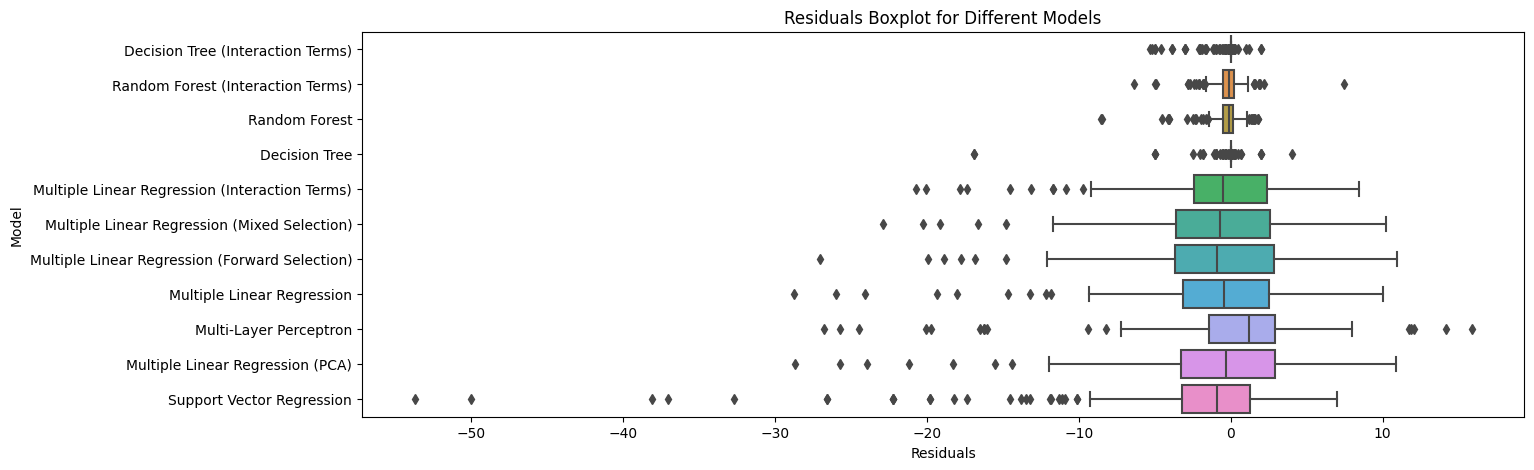

In [705]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category = Warning)

    result_indices = {
        'Decision Tree (Interaction Terms)': test_residuals_dti,
        'Random Forest (Interaction Terms)': test_residuals_rfi,
        'Random Forest': test_residuals_rf,
        'Decision Tree': test_residuals_dt,
        'Multiple Linear Regression (Interaction Terms)': test_residuals_mlri,
        'Multiple Linear Regression (Mixed Selection)': test_residuals_mlri_ms,
        'Multiple Linear Regression (Forward Selection)': test_residuals_mlri_fs,
        'Multiple Linear Regression': test_residuals_mlr,
        'Multi-Layer Perceptron': test_residuals_mlp,
        'Multiple Linear Regression (PCA)': test_residuals_mlrp,
        'Support Vector Regression': test_residuals_svr
    }

    # Test MSE & R2
    print('Test MSE & R2 Score:')
    print(f'\tDecision Tree (Interaction Terms)\t\t{test_mse_dti:.4f}\t\t{test_r2_dti:.4f}')
    print(f'\tRandom Forest (Interaction Terms)\t\t{test_mse_rfi:.4f}\t\t{test_r2_rfi:.4f}')
    print(f'\tRandom Forest\t\t\t\t\t{test_mse_rf:.4f}\t\t{test_r2_rf:.4f}')
    print(f'\tDecision Tree\t\t\t\t\t{test_mse_dt:.4f}\t\t{test_r2_dt:.4f}')
    print(f'\tMultiple Linear Regression (Interaction Terms)\t{test_mse_mlri:.4f}\t\t{test_r2_mlri:.4f}')
    print(f'\tMultiple Linear Regression (Mixed Selection)\t{test_mse_mlri_ms:.4f}\t\t{test_r2_mlri_ms:.4f}')
    print(f'\tMultiple Linear Regression (Forward Selection)\t{test_mse_mlri_fs:.4f}\t\t{test_r2_mlri_fs:.4f}')
    print(f'\tMultiple Linear Regression\t\t\t{test_mse_mlr:.4f}\t\t{test_r2_mlr:.4f}')
    print(f'\tMulti-Layer Perceptron\t\t\t\t{test_mse_mlp:.4f}\t\t{test_r2_mlp:.4f}')
    print(f'\tMultiple Linear Regression (PCA)\t\t{test_mse_mlrp:.4f}\t\t{test_r2_mlrp:.4f}')
    print(f'\tSupport Vector Regression\t\t\t{test_mse_svr:.4f}\t{test_r2_svr:.4f}')

    # Boxplot
    residuals_df = pd.DataFrame({
        'Model': [],
        'Residuals': []
    })
    for model, residuals in result_indices.items():
        temp_df = pd.DataFrame({
            'Model': [model] * len(residuals),
            'Residuals': residuals
        })
        residuals_df = pd.concat([residuals_df, temp_df], ignore_index=True)
    plt.figure(figsize = (15, 5))
    sns.boxplot(y = 'Model', x = 'Residuals', data = residuals_df)
    plt.title('Residuals Boxplot for Different Models')
    plt.xlabel('Residuals')
    plt.ylabel('Model')
    plt.show()

    # Distribution of Prediction Errors for Different Models
    # for model_name, residuals in result_indices.items():
    #     if model_name == 'Decision Tree (Interaction Terms)': continue
    #     plt.figure(figsize = (10, 3))
    #     ax = sns.histplot(residuals, kde = True)
    #     mean = np.mean(residuals)
    #     std_dev = np.std(residuals)
    #     plt.axvline(mean, color = 'r', linestyle = 'dashed', linewidth = 1)
    #     plt.axvline(mean + std_dev, color = 'g', linestyle = 'dashed', linewidth = 1)
    #     plt.axvline(mean - std_dev, color = 'g', linestyle = 'dashed', linewidth = 1)
    #     plt.text(mean, plt.gca().get_ylim()[1] * 0.9, f'Mean = {mean:.2f} ', color = 'r', ha = 'right')
    #     plt.title(f'Distribution of Prediction Errors - {model_name}')
    #     plt.xlabel('Prediction Error')
    #     plt.ylabel('Frequency')
    #     plt.show()

#### Conclusions

##### a